## Image classification with Neural Networks!

In this project we will build a neural network that will be able to classify 10 types of images: Airplanes, Cars, Trucks, horses, cats, dogs, birgs, frogs, ships and deers.

In [66]:
from numpy.random import seed
# If you want to get the same numbers as me add this seed to tensorflow.
seed(888) 

In [120]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import os
import itertools

from IPython.display import display 
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

tf.random.set_seed(404)

In [68]:
# Constants

LABEL_NAMES = ['Plane','Car','Bird','Cat','Deer','Dog','Frog','Horse','Ship','Truck'] # Label from our dataset ordered
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
IMAGE_PIXELS = IMAGE_WIDTH * IMAGE_HEIGHT
COLOUR_CHANNELS = 3
TOTAL_INPUTS = IMAGE_PIXELS * COLOUR_CHANNELS

LOG_DIR = 'tensorboard_cifar_logs/'

VALIDATION_SIZE = 10000
SMALL_TRAIN_SIZE = 1000

### Step 1. Gathering our data

Keras library has a huge amount of data that we can use in order to train our own neural networks. In this project we will use the cifar10, however there are a lot of other free datasets:

https://keras.io/api/datasets/



In [69]:
# Gathering our data - CIFAR 10 Dataset
from keras.datasets import cifar10

(X_train_all, y_train_all) , (X_test_all, y_test_all) = cifar10.load_data() # Returns 2 tuples >> One for training data and another one for test data

### Step 2. Exploring our data

Now let's take a look at our loaded data an try to understand it, and create some assumptions. It's a good step to understand the shape of our datasets.

In [70]:
from keras.preprocessing.image import array_to_img

X_train_all[0] #type >> numpy array

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

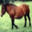

In [71]:
# Checking the image by converting the numbers to an image (array_to_img 

picture = array_to_img(X_train_all[7]) # Checking our references on web you will see that the index 7 correspond to horses
display(picture)

In [72]:
# Checking the shape from our data and what contains in the columns 
print('y train shape:', y_train_all.shape) # 50.000 train labels
print('y test shape:', y_test_all.shape) # 10.000 test labels
print('X train shape:', X_train_all.shape) # 50.000 train features, 32x32, with 3 rgb colors
print('X test shape:', X_test_all.shape) # 10.000 teste features

LABEL_NAMES[y_train_all[7][0]] # Getting the name by using our y_train_all

y train shape: (50000, 1)
y test shape: (10000, 1)
X train shape: (50000, 32, 32, 3)
X test shape: (10000, 32, 32, 3)


'Horse'

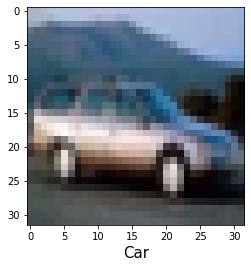

In [73]:
plt.imshow(X_train_all[4])
plt.xlabel(LABEL_NAMES[y_train_all[4][0]], fontsize=15)
plt.show()

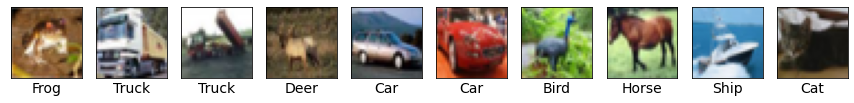

In [74]:
plt.figure(figsize=(15, 5))

for i in range(10):

  plt.subplot(1, 10, i+1) # Subplot cannot start with zero
  plt.yticks([]) # Blank tick marks
  plt.xticks([])
  plt.xlabel(LABEL_NAMES[y_train_all[i][0]], fontsize=14)
  plt.imshow(X_train_all[i])


In [75]:
nr_images, x, y, c = X_train_all.shape
print(f'images = {nr_images} \t | width = {x} \t | height = {y} \t | channels = {c}')

images = 50000 	 | width = 32 	 | height = 32 	 | channels = 3


### Step 3. Preprocessing our data

This is one of the most important steps from setting up a neural network to solve our problem. 

* **Feature Scaling**: We will need to scale our image because, by checking how our learning rate works (it is a small number), reducing the size of our images from 0 - 255 to 0 - 1 will make our model converges more efficiently. For this reason we will divide all datasets to 255.0.

* **Flatten our dataset**: Having 4 dimensions is ok, but it is easier if we transform into a single row of numbers.

* **Validation Dataset**: Creating a validation dataset will help us to boost and tune our model by using an extra amount of data for checking our model and prevent overfitting. In order to create this new dataset, you just need to split up the Test dataset with the same % of the size of the Testing dataset. Example: 60% Training, 20% Validation, 20% Testing.


In [76]:
# Did you know? if we go three levels x_train_all[0][0][0] we are acheiving a specific pixel?
# 1st level >> type of image
# 2nd level >> the proper image
# 3rd level >> the pixel!
# 4th level >> the RGB!!!!!

# 1. Scaling our datasets
X_train_all, X_test_all = X_train_all / 255.0 , X_test_all / 255.0

# 2. Flatten our datasets
X_train_all = X_train_all.reshape(X_train_all.shape[0], TOTAL_INPUTS)  # Parameters >> lenght of the array is the index 0 or use len() + Size of the image
X_test_all = X_test_all.reshape(X_test_all.shape[0], TOTAL_INPUTS)

# After reshaping
print(X_train_all.shape)
print(X_test_all.shape)


(50000, 3072)
(10000, 3072)


In [91]:
# 3. Creating Validation dataset
X_validation = X_train_all[:VALIDATION_SIZE]
y_validation = y_train_all[:VALIDATION_SIZE]

In [78]:
# Removing our samples allocated for validation from our train datasets!
x_train = X_train_all[VALIDATION_SIZE:]
y_train = y_train_all[VALIDATION_SIZE:]

In [79]:
# (Optional but real world uses): Simulation dataset >> a small dataset for running quickly before use lots of data

x_train_xs = x_train[:SMALL_TRAIN_SIZE]
y_train_ys = y_train[:SMALL_TRAIN_SIZE]

### Step 4. Building our model

1. **Define your model:** Set up the structure of the model.

2. **Compile the model:** Set tup the tensorflow with some key informations: How measure the loss, how to measure the weights, how to optmize etc.

3. **Training the model**: Tensorflow will crunchu into the data and fit our neural network.

### Extra topic: Going deeper with Activation Functions, Losses, and Optimizers & Biases

ADD IMAGES HERE LATER

* **Activation Functions:** The activation functions will be used to adjust the weights in our hidden layers. They are composed with a variation between a negative number to a positive one. Each problem to be solved by our neural network, requires a specific activation function. Softmax (used commonly for probabilistic outputs like 80% cat 20% dog), Sigmoid, and ReLU are the most common used nowadays.

Check the Keras API documentation for further details:

https://keras.io/api/layers/activations/

* **Loss Functions:** We have multiple types of functions to calculate our loss. Mean Squared Error, Stochastic Gradient Descent, Categorical Cross Entropy, etc. We are dealing with a classification problem with probabilities, for this reason the Categorical Cross Entropy is the best for us, because its formula is the sum of the costs x predicted probabilities.

* **Optimizers:** The optimizers will improve the efficiency the calculation of our loss, and calculation the weights and biases.


* **Biases:** Besides our weights, our neural network has biases that have a special function in our learning action. While weights adjust the shape of the activation function(flatter or steeper), biases adjust the axis from activation function, moving from the starting point -6 to -3 for example.


In [80]:
# Setting up our first Artificial Neural Network

# Sequential indicates straightforwardly that our models will follow a sequence. Input > Hidden > Output
# 1st Dense: Input layer (3072 inputs) + Hidden layer (128 neurons) >> The amount 3072 is the shape of our images 32 x 32 x 3 rgb. ReLU as activation function.
# 2nd Dense: Hidden layer (64 neurons). ReLU rectifier activation function.
# 3rd Dense: Hidden layer (16 neurons). ReLU rectifier activation function.
# 4th Dense: Output layer. Using softmax as activation functions given the probabilistic nature of our problems. 

model_1 = Sequential([
  Dense(units=128, input_dim=TOTAL_INPUTS, activation='relu', name='m1_hidden1'), # 1st hidden layer + Input layer / 3072 is given the shape of our images 32 x 32 x 3
  Dense(units=64, activation='relu', name='m2_hidden2'), # 2nd hidden layer. You don't need to specify the input_dim! Keras take the previous
  Dense(16, activation='relu', name='m3_hidden3'), # 3rd hidden layer
  Dense(10, activation='softmax', name='output') # Output layer / softmax for probabilities
])

# Compiling our model
model_1.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [81]:
# Checking the architecture from our Neural Network

model_1.summary()

# Params are all connections between nodes (weights) +  biases
# For example in the 1st Dense layer: 32 * 32 * 3 (our inputs) * 128 (connections with hidden layer) + 128 (biases) = 393344
# 2nd layer: 128 (inputs) * 64 (neurons) + 64 (biases)
# 3rd layer: 64 * 16 + 16 
# 4th layer: 16 * 10 + 10

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
m1_hidden1 (Dense)           (None, 128)               393344    
_________________________________________________________________
m2_hidden2 (Dense)           (None, 64)                8256      
_________________________________________________________________
m3_hidden3 (Dense)           (None, 16)                1040      
_________________________________________________________________
output (Dense)               (None, 10)                170       
Total params: 402,810
Trainable params: 402,810
Non-trainable params: 0
_________________________________________________________________


In [82]:
# Model number 2: Adding Regularization techniques to compare performance against model_1

# Adding: Dropout technique

model_2 = Sequential()
model_2.add(Dropout(0.2, seed=42, input_shape=(TOTAL_INPUTS,))) # Add dropout to our model with the input shape
model_2.add(Dense(128, activation='relu', name='m2_hidden1'))
model_2.add(Dense(64, activation='relu', name='m2_hidden2'))
model_2.add(Dense(16, activation='relu', name='m2_hidden3'))
model_2.add(Dense(10, activation='softmax', name='m2_output'))

# Compiling our model
model_2.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [83]:
# Model number 3: Adding Regularization techniques to compare performance against model_1 and model_2

# Adding: Dropout technique + 2nd Dropout at hidden layer

model_3 = Sequential()
model_3.add(Dropout(0.2, seed=42, input_shape=(TOTAL_INPUTS,))) # Add dropout to our model with the input shape
model_3.add(Dense(128, activation='relu', name='m3_hidden1'))
model_3.add(Dropout(0.25, seed=42)) # Add dropout to our model in the hidden shape. We don't need to specify further input_shape
model_3.add(Dense(64, activation='relu', name='m3_hidden2'))
model_3.add(Dense(16, activation='relu', name='m3_hidden3'))
model_3.add(Dense(10, activation='softmax', name='m3_output'))

# Compiling our model
model_3.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

### Extra topic: Setting up our tensorboard

Tensorboard is an excellent strategy to collect the analytics from our model and understand in-depth its performance

In [84]:
from keras.callbacks import TensorBoard
from time import strftime 

def get_tensorboard(model_name):
  folder_name = f'{model_name} at {strftime("%H %M")}'

  # Skip this part for Google Colab
  dir_paths = os.path.join(LOG_DIR, folder_name)

  try: 
    
    os.makedirs(dir_paths) # create directory

  except OSError as err: 
    print(err)

  else:
    print('Directory created successfully')

  # Runs tensorboard
  return TensorBoard(log_dir= dir_paths)

### Step 5. Fitting our model

Let's start tunning and fitting our model for a better performance!

### Overfitting and Regularization

**Overfitting**: Happens when your model learns the train data too well. It's like an addiction! As consequence your model will not generalize well leading to bad predictions with unseen data (lack of generalization). 

**How do we diagnose this problem?** Looking the performance at validation test set. If the validation is not decreasing or rising from a decreasing slope. Another way is to check that your model is doing well but when using real data the predictions are dummy.

**How to fix?:** Regularization! 


**Regularization**: This technique is one of the a great variety of techniques. It applies a 'penalty' or constraint on complexity. Remember Simple is better then Complex! By checking your tensorboard or data provided how well your model is training you can add some breakpoints. 

  1. Early Stop technique: This technique is commonly used when you reach a minimum loss at the validation step, however suddenly the loss start rising up again.

  2. Dropout: This technique ignore ramdomly some neurons during the training steps. During each training step in the input or hidden layer will not be considered

In [85]:
# Model 1 - First Version
samples_per_batch = 1000 # will catch 1000 examples each epoch
nr_epochs = 150

model_1.fit(x= x_train_xs, 
            y= y_train_ys, 
            batch_size= samples_per_batch, 
            epochs=nr_epochs,
            validation_data=(X_validation, y_validation))

# batch_size = divide our training data into small amounts of examples. Try different batch sizes 
# iterations (epochs) = nr training samples / batch size

# IMPORTANT: Note that our validation loss start plummeting and suddenly rising up again. This is may be a signal of overfitting

# Using tensorboard 
# model_1.fit(x= x_train_xs, y= y_train_ys, callbacks=[get_tensorboard('Model 1')])
# Go to the path created
# go to anaconda prompt and them tensorboard --lodgir= C:\.....

Train on 1000 samples, validate on 10000 samples
Epoch 1/150
1000/1000 [==============================] - 1s 548us/step - loss: 2.3105 - accuracy: 0.1210 - val_loss: 2.6823 - val_accuracy: 0.1116
Epoch 2/150
1000/1000 [==============================] - 0s 313us/step - loss: 2.6636 - accuracy: 0.1100 - val_loss: 2.5894 - val_accuracy: 0.1136
Epoch 3/150
1000/1000 [==============================] - 0s 321us/step - loss: 2.5457 - accuracy: 0.1250 - val_loss: 2.3817 - val_accuracy: 0.1028
Epoch 4/150
1000/1000 [==============================] - 0s 305us/step - loss: 2.3486 - accuracy: 0.1030 - val_loss: 2.3655 - val_accuracy: 0.1004
Epoch 5/150
1000/1000 [==============================] - 0s 305us/step - loss: 2.3295 - accuracy: 0.1010 - val_loss: 2.3257 - val_accuracy: 0.1485
Epoch 6/150
1000/1000 [==============================] - 0s 324us/step - loss: 2.3006 - accuracy: 0.1410 - val_loss: 2.3243 - val_accuracy: 0.0959
Epoch 7/150
1000/1000 [==============================] - 0s 304us/ste

In [86]:
# Model 2 - First Version --> Using dropout technique
samples_per_batch = 1000 # will catch 1000 examples each epoch
nr_epochs = 150

model_2.fit(x= x_train_xs, 
            y= y_train_ys, 
            batch_size= samples_per_batch, 
            epochs=nr_epochs,
            validation_data=(X_validation, y_validation))

Train on 1000 samples, validate on 10000 samples
Epoch 1/150
1000/1000 [==============================] - 0s 462us/step - loss: 2.4251 - accuracy: 0.1160 - val_loss: 2.3581 - val_accuracy: 0.0965
Epoch 2/150
1000/1000 [==============================] - 0s 355us/step - loss: 2.3620 - accuracy: 0.0940 - val_loss: 2.3324 - val_accuracy: 0.0811
Epoch 3/150
1000/1000 [==============================] - 0s 352us/step - loss: 2.3308 - accuracy: 0.0930 - val_loss: 2.3263 - val_accuracy: 0.0913
Epoch 4/150
1000/1000 [==============================] - 0s 353us/step - loss: 2.3359 - accuracy: 0.0970 - val_loss: 2.3377 - val_accuracy: 0.0970
Epoch 5/150
1000/1000 [==============================] - 0s 351us/step - loss: 2.3244 - accuracy: 0.1060 - val_loss: 2.2912 - val_accuracy: 0.1357
Epoch 6/150
1000/1000 [==============================] - 0s 350us/step - loss: 2.2764 - accuracy: 0.1450 - val_loss: 2.2870 - val_accuracy: 0.1267
Epoch 7/150
1000/1000 [==============================] - 0s 350us/ste

Models tunning! Second Versions (Model 1 + Model 2)

In [87]:
# Model 1 - Second Version --> Reducing training epochs and using the large dataset

samples_per_batch = 1000 # will catch 1000 examples each epoch
nr_epochs = 100

model_1.fit(x= x_train, 
            y= y_train, 
            batch_size= samples_per_batch, 
            epochs=nr_epochs,
            validation_data=(X_validation, y_validation))

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 2s 60us/step - loss: 1.9395 - accuracy: 0.3161 - val_loss: 1.8518 - val_accuracy: 0.3483
Epoch 2/100
40000/40000 [==============================] - 2s 61us/step - loss: 1.8219 - accuracy: 0.3577 - val_loss: 1.7790 - val_accuracy: 0.3774
Epoch 3/100
40000/40000 [==============================] - 2s 61us/step - loss: 1.7679 - accuracy: 0.3779 - val_loss: 1.7601 - val_accuracy: 0.3817
Epoch 4/100
40000/40000 [==============================] - 2s 62us/step - loss: 1.7428 - accuracy: 0.3849 - val_loss: 1.7257 - val_accuracy: 0.3916
Epoch 5/100
40000/40000 [==============================] - 2s 61us/step - loss: 1.7079 - accuracy: 0.3964 - val_loss: 1.7097 - val_accuracy: 0.3942
Epoch 6/100
40000/40000 [==============================] - 2s 61us/step - loss: 1.6841 - accuracy: 0.4056 - val_loss: 1.6883 - val_accuracy: 0.4006
Epoch 7/100
40000/40000 [==============================] - 2s 

In [88]:
# Model 2 - Second Version --> Using dropout technique + reducing epochs + using a large dataset
samples_per_batch = 1000 # will catch 1000 examples each epoch
nr_epochs = 100

model_2.fit(x= x_train, 
            y= y_train, 
            batch_size= samples_per_batch, 
            epochs=nr_epochs,
            validation_data=(X_validation, y_validation))

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 3s 87us/step - loss: 2.0056 - accuracy: 0.2912 - val_loss: 1.9095 - val_accuracy: 0.3259
Epoch 2/100
40000/40000 [==============================] - 4s 88us/step - loss: 1.9166 - accuracy: 0.3140 - val_loss: 1.8570 - val_accuracy: 0.3398
Epoch 3/100
40000/40000 [==============================] - 5s 116us/step - loss: 1.8624 - accuracy: 0.3277 - val_loss: 1.8273 - val_accuracy: 0.3406
Epoch 4/100
40000/40000 [==============================] - 4s 101us/step - loss: 1.8215 - accuracy: 0.3463 - val_loss: 1.7862 - val_accuracy: 0.3581
Epoch 5/100
40000/40000 [==============================] - 4s 89us/step - loss: 1.7903 - accuracy: 0.3568 - val_loss: 1.7497 - val_accuracy: 0.3712
Epoch 6/100
40000/40000 [==============================] - 4s 88us/step - loss: 1.7634 - accuracy: 0.3689 - val_loss: 1.7458 - val_accuracy: 0.3743
Epoch 7/100
40000/40000 [==============================] - 4

In [89]:
# Model 3 --> Using 2x dropout technique + reducing epochs + using a large dataset
samples_per_batch = 1000 # will catch 1000 examples each epoch
nr_epochs = 100

model_2.fit(x= x_train, 
            y= y_train, 
            batch_size= samples_per_batch, 
            epochs=nr_epochs,
            validation_data=(X_validation, y_validation))

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 4s 88us/step - loss: 1.3313 - accuracy: 0.5228 - val_loss: 1.4430 - val_accuracy: 0.4850
Epoch 2/100
40000/40000 [==============================] - 3s 87us/step - loss: 1.3333 - accuracy: 0.5213 - val_loss: 1.4322 - val_accuracy: 0.4931
Epoch 3/100
40000/40000 [==============================] - 4s 88us/step - loss: 1.3269 - accuracy: 0.5207 - val_loss: 1.4241 - val_accuracy: 0.4943
Epoch 4/100
40000/40000 [==============================] - 4s 88us/step - loss: 1.3297 - accuracy: 0.5227 - val_loss: 1.4419 - val_accuracy: 0.4917
Epoch 5/100
40000/40000 [==============================] - 3s 87us/step - loss: 1.3290 - accuracy: 0.5247 - val_loss: 1.4240 - val_accuracy: 0.4934
Epoch 6/100
40000/40000 [==============================] - 3s 87us/step - loss: 1.3219 - accuracy: 0.5257 - val_loss: 1.4271 - val_accuracy: 0.4984
Epoch 7/100
40000/40000 [==============================] - 4s 

### Step 6: Making Predictions!

In [92]:
# 1. Let's take some image as an example for our prediction

X_validation.shape # 10000 (images), 3072 (pixels! our 32 x 32 x 3)

X_validation[0] # takes the first image! Shape: (3072,) 3072 pixels

(10000, 3072)

In [94]:
# We need to expand the dimensions for fitting the predict function
test_image = np.expand_dims(X_validation[0], axis=0) # Add the second dimension at the beginning
test_image.shape

(1, 3072)

In [96]:
# The .predict function will return an array with probabilities for each category

model_2.predict(test_image) # The total must be 1 or 100%


array([[0.0180363 , 0.0032155 , 0.04953308, 0.12800889, 0.34632474,
        0.05946006, 0.3318265 , 0.06268223, 0.00035633, 0.00055636]],
      dtype=float32)

In [98]:
# Predicting all the array

model_2.predict(X_validation).shape # Shape: 10000 images / 10 classifications

(10000, 10)

In [99]:
# Keras also have a predictor for classes! So it will return which classification is
model_2.predict_classes(test_image)

array([4])

In [100]:
# Validating the prediction with our labels y_validation

y_validation[0]

array([6], dtype=uint8)

In [101]:
# Let's printing the first 10 images in the X_validation

for img in range(10):

  # Expand the dimensions to fit our predictor
  test_img = np.expand_dims(X_validation[img], axis=0)

  # Predicting classes and saving to an image
  predicted_img = model_2.predict_classes(test_img)[0]

  print(f'Actual value:{y_validation[img][0]} vs Predicted value:{predicted_img}')


Actual value:6 vs Predicted value:4
Actual value:9 vs Predicted value:1
Actual value:9 vs Predicted value:9
Actual value:4 vs Predicted value:4
Actual value:1 vs Predicted value:8
Actual value:1 vs Predicted value:7
Actual value:2 vs Predicted value:2
Actual value:7 vs Predicted value:7
Actual value:8 vs Predicted value:8
Actual value:3 vs Predicted value:2


### Step 7. Model Evaluation

Let's use Recall + Precision + + FScore + Accuracy + Confusion Matrix to evaluate our Neural Network

In [109]:
# Model Evaluation

# Recall Score = True Positives / (True Positives + False Negatives)
# Precision = True Positives / (True Positives + False Positives)
# F1 Score = 2 x (precision x recall) / (precision + recall)

test_loss, test_accuracy = model_2.evaluate(x=X_test_all, y=y_test_all)

print(f'Test loss: {test_loss:0.5}, Test Accuracy: {test_accuracy :0.1%}') # Loss: 1.4069 / Accuracy: 50.3%

10000/10000 [==============================] - 1s 53us/step
Test loss: 1.407, Test Accuracy: 50.3%


In [112]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix

predictions = model_2.predict_classes(X_test_all)

conf_matrix = confusion_matrix(y_true= y_test_all, y_pred= predictions)

conf_matrix.shape # 10 x 10 matrix 

nr_rows = conf_matrix.shape[0]
nr_columns = conf_matrix.shape[1]

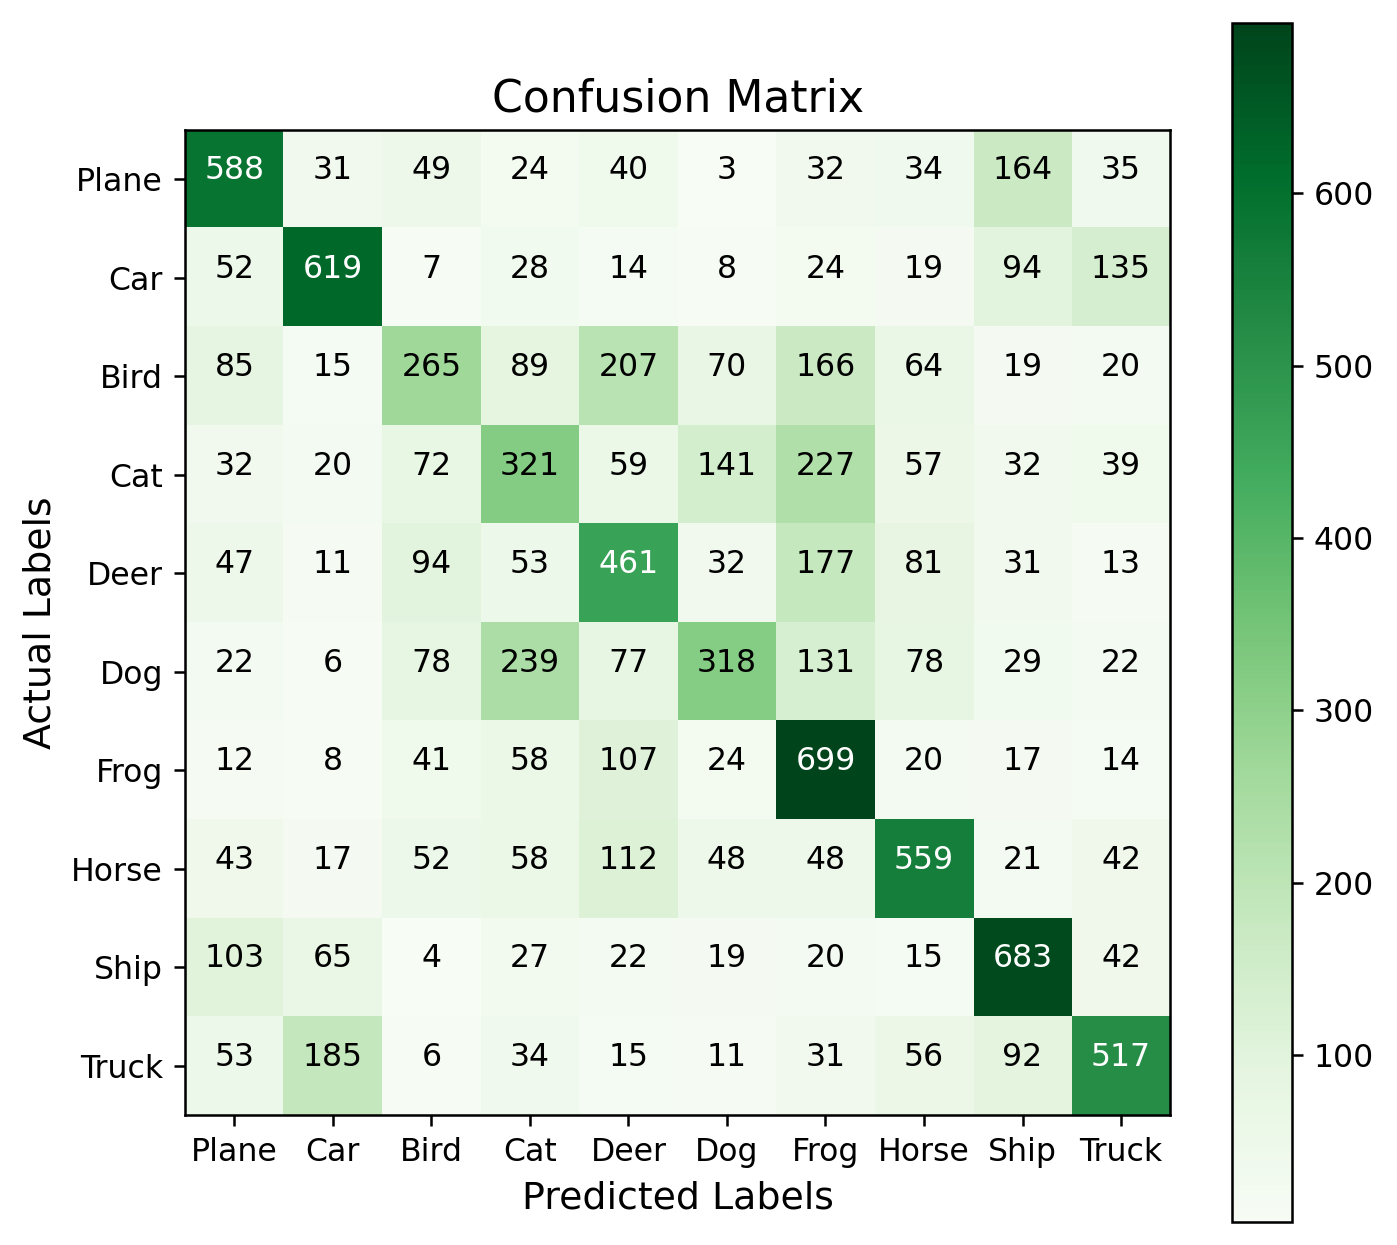

In [128]:
plt.figure(figsize=(7, 7), dpi= 227)

plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('Actual Labels', fontsize=12)

# Adjusting the tick marks
tick_marks = np.arange(10) # 10 = number of classes 

plt.xticks(tick_marks, LABEL_NAMES)
plt.yticks(tick_marks, LABEL_NAMES)

plt.imshow(conf_matrix, cmap=plt.cm.Greens)

plt.colorbar()

for i, j in itertools.product(range(nr_rows), range(nr_columns)):

  plt.text(j , i, conf_matrix[i , j], # Remember [rows , columns] you can access the cell
           horizontalalignment='center', # Align all items to the center
           color='white' if conf_matrix[i , j] > 450 else 'black') # Conditional formatting

plt.show()

In [132]:
# Collecting the diagonal (True positives)
np.diag(conf_matrix)

recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis= 1)
print('Recall for each category:', recall)

precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis= 0)
print('Precision for each category:', precision)

Recall for each category: [0.588 0.619 0.265 0.321 0.461 0.318 0.699 0.559 0.683 0.517]
Precision for each category: [0.56702025 0.63357216 0.39670659 0.34479055 0.41382406 0.47181009
 0.44951768 0.56866734 0.57783418 0.58816837]


In [134]:
avg_recall = np.mean(recall)
print('Average recall - All categories (full model):', avg_recall)
avg_precision = np.mean(precision)
print('Average precision - All categories (full model):', avg_precision)

Average recall - All categories (full model): 0.503
Average precision - All categories (full model): 0.5011911273749976


In [136]:
f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall)
print('F-Score:', f1_score)

F-Score: 0.5020939345055212
